####  NOTE: You have to run predict_validation (in train folder) before running this analysis.

In [1]:
import glob
import os
import sys

import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import widgets
from matplotlib import colors
from scipy.spatial.distance import cdist

from collections import OrderedDict
import pandas as pd

In [2]:
cmap = colors.ListedColormap(['orange', 'red'])
cmap_ground_truth = colors.ListedColormap(['lime'])
cmap_pred = colors.ListedColormap(['yellow'])
cmap_pink = colors.ListedColormap(['pink', 'red'])
cmap_red = colors.ListedColormap(['crimson'])
cmap_orange = colors.ListedColormap(['darkorange'])
cmap_black = colors.ListedColormap(['black'])
%matplotlib inline

In [3]:
module_root = '..'
sys.path.append(module_root)
from settings import train_folder

In [4]:
train_folder = '/home/mehrtash/dropbox/qanat_v2/intermediate/train/'
output_folder = '/home/mehrtash/dropbox/qanat_v2/intermediate/analysis/'
if not os.path.isdir(output_folder):
    os.mkdir(output_folder)

## Select Model Folder

In [5]:
model_list = sorted(os.listdir(train_folder))
model_list.remove('board_logs')
# model_list.remove('archive')
model_dropdown = widgets.Dropdown(
    options=model_list,
    value=model_list[2],
    description='source: ',
)
display(model_dropdown)

Dropdown(description='source: ', index=2, options=('f1', 'f2', 'f3', 'f4', 'f5'), value='f3')

In [6]:
val_pred_folder = os.path.join(train_folder, model_dropdown.value, 'validation_predictions')
labels = sorted(glob.glob( val_pred_folder + '/*_label.nrrd'))
print('no of labels: {}'.format(len(labels)))
labels_dropdown = widgets.Dropdown(
    options=labels,
    value=labels[1],
    description='label: ',
)
display(labels_dropdown)

no of labels: 2


Dropdown(description='label: ', index=1, options=('/home/mehrtash/dropbox/qanat_v2/intermediate/train/f3/valid…

In [7]:
file_prefix = model_dropdown.value + '_' + os.path.basename(labels_dropdown.value).replace('.nrrd', '')

In [8]:
label_path = labels_dropdown.value
label = sitk.ReadImage(label_path)
# label_border = sitk.BinaryDilate(label, 2)
label_border = sitk.BinaryDilate(label, 3) - sitk.BinaryErode(label, 2)
label_bnd = sitk.BinaryDilate(label, 1) - label
#
image = sitk.ReadImage(label_path.replace('_label.nrrd', '.nrrd'))
#
pred = sitk.ReadImage(label_path.replace('_label.nrrd', '_pred.nrrd'))
#
lower_bound_th = 250 
pred_th = sitk.BinaryThreshold(pred, lower_bound_th, 10000, 1, 0)
pred_th_border = sitk.BinaryDilate(pred_th, 2) - sitk.BinaryErode(pred_th, 3)
pred_th_bnd = pred_th - sitk.BinaryErode(pred_th, 1)

In [9]:
image_nda = sitk.GetArrayFromImage(image)
label_nda = sitk.GetArrayFromImage(label)
label_nda_border = sitk.GetArrayFromImage(label_border)
pred_nda = sitk.GetArrayFromImage(pred_th)
pred_nda_border = sitk.GetArrayFromImage(pred_th_border)
#
label_bnd = sitk.BinaryDilate(label, 1) - label
label_bnd_nda = sitk.GetArrayFromImage(label_bnd)
label_bnd_nda = np.ma.masked_where(label_bnd_nda== 0, label_bnd_nda)
pred_th_bnd = pred_th - sitk.BinaryErode(pred_th, 1)
pred_bnd_nda = sitk.GetArrayFromImage(pred_th_bnd)

In [10]:
ccf = sitk.ConnectedComponentImageFilter()
ccf.SetFullyConnected(True)
ccf_labelmap_true = ccf.Execute(label)
stats_filter = sitk.LabelStatisticsImageFilter()
stats_filter.Execute(ccf_labelmap_true, ccf_labelmap_true)
labels_true= list(stats_filter.GetLabels())
labels_true.remove(0)
#
ccf_labelmap_pred = ccf.Execute(pred_th)
stats_filter.Execute(ccf_labelmap_pred, ccf_labelmap_pred)
labels_pred = list(stats_filter.GetLabels())
labels_pred.remove(0)

#

ccf_nda = sitk.GetArrayFromImage(ccf_labelmap_true)
ccf_pred_nda = sitk.GetArrayFromImage(ccf_labelmap_pred)

#

detection_threshold = 5
tp_nda = np.copy(ccf_nda)
fn_nda = np.copy(ccf_nda)
tp_count = 0
fn_count = 0
for label_value in labels_true:
    if np.sum(pred_nda[ccf_nda == label_value]) >= detection_threshold:
        tp_count += 1
        fn_nda[fn_nda==label_value] = 0
    else:
        tp_nda[tp_nda==label_value] = 0
        fn_count += 1
tp_nda[tp_nda>0] = 1

#

fp_count = 0
tp2_count = 0
fp_nda = np.copy(ccf_pred_nda)
for label_value in labels_pred:
    if np.sum(label_nda[ccf_pred_nda == label_value]) > detection_threshold:
        fp_nda[fp_nda==label_value] = 0
        tp2_count +=1
    else:
        fp_count += 1
fp_nda[fp_nda>0] = 1

#

In [11]:
min_componenet_size = 10

filtered_count = 0
for label_value in labels_pred:
    # print(label_value)
    component_size = np.count_nonzero((ccf_pred_nda[ccf_pred_nda==label_value]))
    if component_size < min_componenet_size:
        filtered_indices = np.where(ccf_pred_nda == label_value)
        # print(filtered_indices)
        ccf_pred_nda[filtered_indices] = 0
        pred_nda[filtered_indices] = 0
        pred_bnd_nda[filtered_indices] = 0
        fp_nda[filtered_indices] = 0
        filtered_count += 1
        labels_pred.remove(label_value)
print('{} components were rejected'.format(filtered_count))

81 components were rejected


In [12]:
label_nda = np.ma.masked_where(label_nda== 0, label_nda)
label_nda_border = np.ma.masked_where(label_nda_border== 0, label_nda_border)
pred_nda = np.ma.masked_where(pred_nda==0, pred_nda)
pred_nda_border = np.ma.masked_where(pred_nda_border==0, pred_nda_border)
pred_bnd_nda = np.ma.masked_where(pred_bnd_nda==0, pred_bnd_nda)

In [13]:
tp_nda = np.ma.masked_where(tp_nda == 0, tp_nda)
fn_nda = np.ma.masked_where(fn_nda == 0, fn_nda)
fp_nda = np.ma.masked_where(fp_nda == 0, fp_nda)
fp_border = sitk.BinaryDilate(sitk.GetImageFromArray(fp_nda), 2)
fp_border_nda = sitk.GetArrayFromImage(fp_border)
fp_border_nda = np.ma.masked_where(fp_border_nda == 0, fp_border_nda)

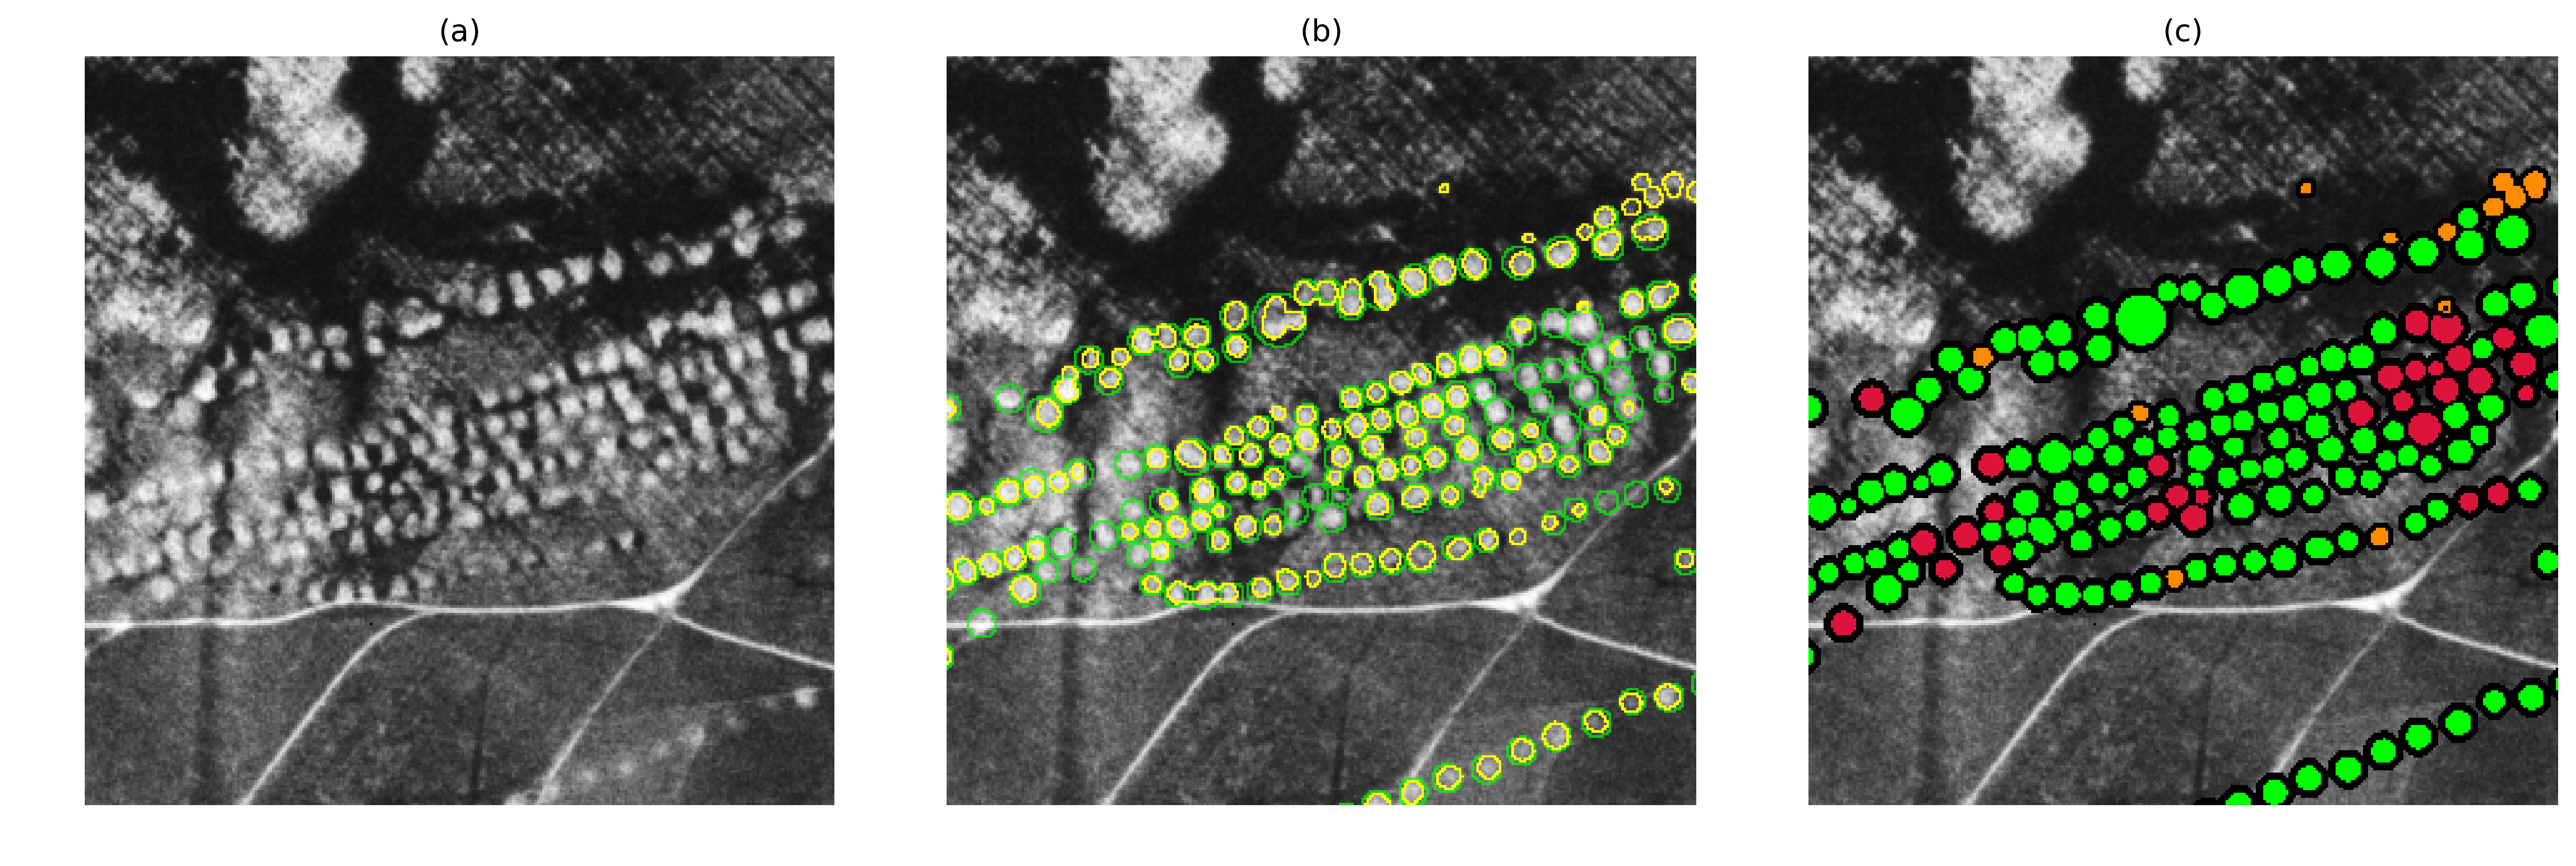

In [14]:
start_x = 700
end_x = 1000
start_y = 700
end_y = 1000
#
plt.figure(figsize=(15,5), dpi=400)
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=0.15, hspace=0.15)

plt.subplot(131)
plt.imshow(image_nda[start_x:end_x, start_y:end_y], cmap=plt.cm.gray)
plt.title('(a)')
plt.axis('off')
#
plt.subplot(132)
plt.imshow(image_nda[start_x:end_x, start_y:end_y], cmap=plt.cm.gray)
plt.imshow(label_bnd_nda[start_x:end_x, start_y:end_y], cmap=cmap_ground_truth, alpha=0.7)
plt.imshow(pred_bnd_nda[start_x:end_x, start_y:end_y], cmap=cmap_pred,alpha=1)
plt.title('(b)')
plt.axis('off')
#
plt.subplot(133)
plt.imshow(image_nda[start_x:end_x, start_y:end_y], cmap=plt.cm.gray)
plt.imshow(label_nda_border[start_x:end_x, start_y:end_y], cmap=cmap_black)
plt.imshow(tp_nda[start_x:end_x, start_y:end_y], cmap=cmap_ground_truth)
plt.imshow(fn_nda[start_x:end_x, start_y:end_y], cmap=cmap_red)
plt.imshow(fp_border_nda[start_x:end_x, start_y:end_y], cmap=cmap_black)
plt.imshow(fp_nda[start_x:end_x, start_y:end_y], cmap=cmap_orange)
plt.title('(c)')
plt.axis('off')
plt.savefig(os.path.join(output_folder, file_prefix + '_zoomed.png'))